# EDA

## Import Libraries

In [10]:
import numpy as np
import pandas as pd
from pandas import DataFrame
import seaborn as sns
import matplotlib.pyplot as plt
import sweetviz as sv

import model.train as train
import model.config as config
import utils as utils
import model.dataset.season_game as sg

from pandas_profiling import ProfileReport
from yellowbrick.target import FeatureCorrelation
import qgrid

## Setup

In [11]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
sns.set(style="whitegrid")
#sns.set(style='whitegrid', palette=sns.color_palette(
 #   "BuGn_r"), font_scale=1.5, color_codes=True)

#pd.options.display.max_columns = None
#pd.set_option("display.max_colwidth", None)
#from IPython.core.interactiveshell import InteractiveShell
#InteractiveShell.ast_node_interactivity = "all"
pd.set_option("display.max_rows", 50)
pd.set_option("display.max_colwidth", 50)
pd.set_option("display.max_columns", 50)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Utils functions

In [12]:
def show_qgrid(df_):
    qgrid_widget = qgrid.show_grid(df_, show_toolbar=True , grid_options={'forceFitColumns': False, 'defaultColumnWidth': 200})
    qgrid_widget

## Load dataset

In [58]:
raw_ds = sg.load_raw_season_games_dataset()
dataset = sg.load_season_games_dataset()
df = dataset

In [14]:
columns = config.X_COLS + config.Y_CLF_COL + config.Y_REG_COL

### Validate dataset

In [115]:
test_df = pd.DataFrame({"B": [1, 2, 3, 4, 5, np.nan], "C": [1, 2, 3, 4, 5, 6], "D": [1, np.nan, 3, 4, 5, 6]})
#test_df.apply(lambda x : x.shift(1).expanding().mean())
#test_df.shift(1).expanding(min_periods=-1).mean()
test_df.shift(1).rolling(window=5, min_periods=0).sum()
#test_df[['B', 'C']] = test_df[['B', 'C']].fillna(0)




,B,C,D
0,0.0,0.0,0.0
1,1.0,1.0,1.0
2,3.0,3.0,1.0
3,6.0,6.0,4.0
4,10.0,10.0,8.0
5,15.0,15.0,13.0


In [26]:
cols = [
'GAME_DATE',
'MATCHUP_HOME',
'FGM_HOME',
'FGM_MEAN_HOME',
'FGA_HOME',
'FGA_MEAN_HOME',
'FG_PCT_HOME',
'FG_PCT_MEAN_HOME',
'FG3M_HOME',
'FG3M_MEAN_HOME',
'FG3A_HOME',
'FG3A_MEAN_HOME',
'FG3_PCT_HOME',
'FG3_PCT_MEAN_HOME',
'FTM_HOME',
'FTM_MEAN_HOME',    
'FTA_HOME',
'FTA_MEAN_HOME',    
'FT_PCT_HOME',
'FT_PCT_MEAN_HOME',
'OREB_HOME',
'OREB_MEAN_HOME',
'DREB_HOME',
'DREB_MEAN_HOME',
'REB_HOME',
'REB_MEAN_HOME',
'AST_HOME',
'AST_MEAN_HOME',
'STL_HOME',
'STL_MEAN_HOME',
'BLK_HOME',
'BLK_MEAN_HOME',
'TOV_HOME',
'TOV_MEAN_HOME',
'PF_HOME',
'PF_MEAN_HOME',
'PTS_HOME',
'PTS_MEAN_HOME',
'PLUS_MINUS_HOME',
'PLUS_MINUS_MEAN_HOME'
]

In [27]:
cond = ((df.TEAM_ABBREVIATION_HOME == 'MIL') | (df.TEAM_ABBREVIATION_AWAY == 'MIL')) \
    & (df.SEASON == 2018)
#list(df[cond].columns)
df[cond][cols]

,GAME_DATE,MATCHUP_HOME,FGM_HOME,FGM_MEAN_HOME,FGA_HOME,FGA_MEAN_HOME,FG_PCT_HOME,FG_PCT_MEAN_HOME,FG3M_HOME,FG3M_MEAN_HOME,FG3A_HOME,FG3A_MEAN_HOME,FG3_PCT_HOME,FG3_PCT_MEAN_HOME,FTM_HOME,FTM_MEAN_HOME,FTA_HOME,FTA_MEAN_HOME,FT_PCT_HOME,FT_PCT_MEAN_HOME,OREB_HOME,OREB_MEAN_HOME,DREB_HOME,DREB_MEAN_HOME,REB_HOME,REB_MEAN_HOME,AST_HOME,AST_MEAN_HOME,STL_HOME,STL_MEAN_HOME,BLK_HOME,BLK_MEAN_HOME,TOV_HOME,TOV_MEAN_HOME,PF_HOME,PF_MEAN_HOME,PTS_HOME,PTS_MEAN_HOME,PLUS_MINUS_HOME,PLUS_MINUS_MEAN_HOME
GAME_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0021800003,2018-10-17,CHA vs. MIL,41,NaN,92,NaN,0.446,NaN,16,NaN,38,NaN,0.421,NaN,14,NaN,22,NaN,0.636,NaN,9,NaN,32,NaN,41,NaN,21,NaN,8,NaN,9,NaN,11,NaN,19,NaN,112,NaN,-1,NaN
0021800023,2018-10-19,MIL vs. IND,44,42.000000,93,85.000000,0.473,0.494000,17,14.000000,46,34.000000,0.370,0.412000,13,15.000000,21,20.000000,0.619,0.750000,11,11.000000,39,46.000000,50,57.000000,27,26.000000,9,5.000000,8,4.000000,17,21.000000,26,25.000000,118,113.000000,17,1.000000
0021800042,2018-10-22,MIL vs. NYK,45,43.000000,96,89.000000,0.469,0.483500,17,15.500000,40,40.000000,0.425,0.391000,17,14.000000,24,20.500000,0.708,0.684500,19,11.000000,36,42.500000,55,53.500000,27,26.500000,5,7.000000,9,6.000000,15,19.000000,18,25.500000,124,115.500000,11,9.000000
0021800059,2018-10-24,MIL vs. PHI,41,43.666667,100,91.333333,0.410,0.478667,13,16.000000,43,40.000000,0.302,0.402333,28,15.000000,30,21.666667,0.933,0.692333,9,13.666667,42,40.333333,51,54.000000,24,26.666667,7,6.333333,10,7.000000,11,17.666667,27,23.000000,123,118.333333,15,9.666667
0021800071,2018-10-26,MIN vs. MIL,36,40.600000,112,88.600000,0.321,0.460000,10,10.400000,43,26.800000,0.233,0.389400,13,24.600000,18,28.400000,0.722,0.844800,17,10.600000,32,31.400000,49,42.000000,19,24.000000,10,9.400000,6,5.800000,8,14.600000,15,22.400000,95,116.200000,-30,0.600000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0021801154,2019-04-01,BKN vs. MIL,39,40.129870,94,89.337662,0.415,0.450000,16,12.597403,44,35.714286,0.364,0.352740,27,19.142857,34,25.727273,0.794,0.745519,16,10.727273,39,35.350649,55,46.077922,19,23.831169,6,6.610390,5,4.220779,23,15.051948,26,21.727273,121,112.000000,-10,-0.285714
0021801177,2019-04-04,PHI vs. MIL,45,41.333333,95,87.935897,0.474,0.470923,18,10.833333,36,30.256410,0.500,0.358179,14,21.666667,18,27.987179,0.778,0.774372,4,11.000000,39,36.782051,43,47.782051,36,26.846154,4,7.461538,8,5.243590,13,15.102564,26,21.474359,122,115.166667,-6,2.743590
0021801193,2019-04-06,MIL vs. BKN,49,43.329114,88,91.037975,0.557,0.476848,16,13.481013,34,38.139241,0.471,0.353785,14,17.924051,21,23.139241,0.667,0.773987,6,9.291139,37,40.341772,43,49.632911,28,26.101266,7,7.506329,4,5.962025,14,13.848101,18,19.658228,128,118.063291,-5,9.303797


In [66]:
pd.set_option("display.max_columns", 200)
dataset.head()

,SEASON_ID,TEAM_ID_HOME,TEAM_ABBREVIATION_HOME,TEAM_NAME_HOME,GAME_DATE,MATCHUP_HOME,WL_HOME,MIN_HOME,FGM_HOME,FGA_HOME,FG_PCT_HOME,FG3M_HOME,FG3A_HOME,FG3_PCT_HOME,FTM_HOME,FTA_HOME,FT_PCT_HOME,OREB_HOME,DREB_HOME,REB_HOME,AST_HOME,STL_HOME,BLK_HOME,TOV_HOME,PF_HOME,PTS_HOME,PLUS_MINUS_HOME,W_L_HOME,W_L_CUM_HOME,W_L_L10_CUM_HOME,SEASON_HOME,LOCATION_HOME,UNIQUE_MATCHUP_HOME,FGM_ML5_HOME,FGA_ML5_HOME,FG_PCT_ML5_HOME,FG3M_ML5_HOME,FG3A_ML5_HOME,FG3_PCT_ML5_HOME,FTM_ML5_HOME,FTA_ML5_HOME,FT_PCT_ML5_HOME,OREB_ML5_HOME,DREB_ML5_HOME,REB_ML5_HOME,AST_ML5_HOME,STL_ML5_HOME,BLK_ML5_HOME,TOV_ML5_HOME,PF_ML5_HOME,PTS_ML5_HOME,PLUS_MINUS_ML5_HOME,W_L_ML5_HOME,FGM_MEAN_HOME,FGA_MEAN_HOME,FG_PCT_MEAN_HOME,FG3M_MEAN_HOME,FG3A_MEAN_HOME,FG3_PCT_MEAN_HOME,FTM_MEAN_HOME,FTA_MEAN_HOME,FT_PCT_MEAN_HOME,OREB_MEAN_HOME,DREB_MEAN_HOME,REB_MEAN_HOME,AST_MEAN_HOME,STL_MEAN_HOME,BLK_MEAN_HOME,TOV_MEAN_HOME,PF_MEAN_HOME,PTS_MEAN_HOME,PLUS_MINUS_MEAN_HOME,FGM_L10_HOME,FGA_L10_HOME,FG_PCT_L10_HOME,FG3M_L10_HOME,FG3A_L10_HOME,FG3_PCT_L10_HOME,FTM_L10_HOME,FTA_L10_HOME,FT_PCT_L10_HOME,OREB_L10_HOME,DREB_L10_HOME,REB_L10_HOME,AST_L10_HOME,STL_L10_HOME,BLK_L10_HOME,TOV_L10_HOME,PF_L10_HOME,PTS_L10_HOME,PLUS_MINUS_L10_HOME,TEAM_ID_AWAY,TEAM_ABBREVIATION_AWAY,TEAM_NAME_AWAY,MATCHUP_AWAY,WL_AWAY,FGM_AWAY,FGA_AWAY,FG_PCT_AWAY,FG3M_AWAY,FG3A_AWAY,FG3_PCT_AWAY,FTM_AWAY,FTA_AWAY,FT_PCT_AWAY,OREB_AWAY,DREB_AWAY,REB_AWAY,AST_AWAY,STL_AWAY,BLK_AWAY,TOV_AWAY,PF_AWAY,PTS_AWAY,PLUS_MINUS_AWAY,W_L_AWAY,W_L_CUM_AWAY,W_L_L10_CUM_AWAY,LOCATION_AWAY,FGM_ML5_AWAY,FGA_ML5_AWAY,FG_PCT_ML5_AWAY,FG3M_ML5_AWAY,FG3A_ML5_AWAY,FG3_PCT_ML5_AWAY,FTM_ML5_AWAY,FTA_ML5_AWAY,FT_PCT_ML5_AWAY,OREB_ML5_AWAY,DREB_ML5_AWAY,REB_ML5_AWAY,AST_ML5_AWAY,STL_ML5_AWAY,BLK_ML5_AWAY,TOV_ML5_AWAY,PF_ML5_AWAY,PTS_ML5_AWAY,PLUS_MINUS_ML5_AWAY,W_L_ML5_AWAY,FGM_MEAN_AWAY,FGA_MEAN_AWAY,FG_PCT_MEAN_AWAY,FG3M_MEAN_AWAY,FG3A_MEAN_AWAY,FG3_PCT_MEAN_AWAY,FTM_MEAN_AWAY,FTA_MEAN_AWAY,FT_PCT_MEAN_AWAY,OREB_MEAN_AWAY,DREB_MEAN_AWAY,REB_MEAN_AWAY,AST_MEAN_AWAY,STL_MEAN_AWAY,BLK_MEAN_AWAY,TOV_MEAN_AWAY,PF_MEAN_AWAY,PTS_MEAN_AWAY,PLUS_MINUS_MEAN_AWAY,FGM_L10_AWAY,FGA_L10_AWAY,FG_PCT_L10_AWAY,FG3M_L10_AWAY,FG3A_L10_AWAY,FG3_PCT_L10_AWAY,FTM_L10_AWAY,FTA_L10_AWAY,FT_PCT_L10_AWAY,OREB_L10_AWAY,DREB_L10_AWAY,REB_L10_AWAY,AST_L10_AWAY,STL_L10_AWAY,BLK_L10_AWAY,TOV_L10_AWAY,PF_L10_AWAY,PTS_L10_AWAY,PLUS_MINUS_L10_AWAY,HOME_WINS,HOME_POINT_SPREAD,PTS,HOME_PLUS_MINUS_ML5,SEASON,GAME_DATE_EST
GAME_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0020200001,22002,1610612753,ORL,Orlando Magic,2002-10-29,ORL vs. PHI,W,240,36,81,0.444,6,18,0.333,17,22,0.773,8,31,39,24,4,8,15,26,95,7,1,NaN,NaN,2002,HOME,1610612753-1610612755,43.2,89.2,0.4840,13.0,33.4,0.3882,11.6,14.2,0.8166,9.0,29.2,38.2,27.4,7.0,5.2,11.8,16.8,111.0,-2.6,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1610612755,PHI,Philadelphia 76ers,PHI @ ORL,L,31,78,0.397,2,8,0.250,24,32,0.750,11,35,46,19,10,1,20,22,88,-7,-1,NaN,NaN,AWAY,38.2,81.6,0.4676,10.6,28.8,0.3640,21.2,28.2,0.7368,8.0,36.4,44.4,28.6,6.2,7.0,12.2,19.4,108.2,7.6,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,7,183,-10.2,2002,2002-10-29
0020200002,22002,1610612758,SAC,Sacramento Kings,2002-10-29,SAC vs. CLE,W,240,36,80,0.450,6,15,0.400,16,23,0.696,15,33,48,21,12,10,20,19,94,27,1,NaN,NaN,2002,HOME,1610612739-1610612758,40.2,85.0,0.4726,12.6,34.2,0.3648,11.8,16.4,0.7584,7.8,32.6,40.4,24.4,7.0,4.4,14.2,20.6,104.8,-3.8,-3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1610612739,CLE,Cleveland Cavaliers,CLE @ SAC,L,27,83,0.325,1,4,0.250,12,20,0.600,17,29,46,14

In [64]:
ds_columns = list(dataset.columns)
ds_columns.sort()
ds_columns

['AST_AWAY',
 'AST_HOME',
 'AST_L10_AWAY',
 'AST_L10_HOME',
 'AST_MEAN_AWAY',
 'AST_MEAN_HOME',
 'AST_ML5_AWAY',
 'AST_ML5_HOME',
 'BLK_AWAY',
 'BLK_HOME',
 'BLK_L10_AWAY',
 'BLK_L10_HOME',
 'BLK_MEAN_AWAY',
 'BLK_MEAN_HOME',
 'BLK_ML5_AWAY',
 'BLK_ML5_HOME',
 'DREB_AWAY',
 'DREB_HOME',
 'DREB_L10_AWAY',
 'DREB_L10_HOME',
 'DREB_MEAN_AWAY',
 'DREB_MEAN_HOME',
 'DREB_ML5_AWAY',
 'DREB_ML5_HOME',
 'FG3A_AWAY',
 'FG3A_HOME',
 'FG3A_L10_AWAY',
 'FG3A_L10_HOME',
 'FG3A_MEAN_AWAY',
 'FG3A_MEAN_HOME',
 'FG3A_ML5_AWAY',
 'FG3A_ML5_HOME',
 'FG3M_AWAY',
 'FG3M_HOME',
 'FG3M_L10_AWAY',
 'FG3M_L10_HOME',
 'FG3M_MEAN_AWAY',
 'FG3M_MEAN_HOME',
 'FG3M_ML5_AWAY',
 'FG3M_ML5_HOME',
 'FG3_PCT_AWAY',
 'FG3_PCT_HOME',
 'FG3_PCT_L10_AWAY',
 'FG3_PCT_L10_HOME',
 'FG3_PCT_MEAN_AWAY',
 'FG3_PCT_MEAN_HOME',
 'FG3_PCT_ML5_AWAY',
 'FG3_PCT_ML5_HOME',
 'FGA_AWAY',
 'FGA_HOME',
 'FGA_L10_AWAY',
 'FGA_L10_HOME',
 'FGA_MEAN_AWAY',
 'FGA_MEAN_HOME',
 'FGA_ML5_AWAY',
 'FGA_ML5_HOME',
 'FGM_AWAY',
 'FGM_HOME',
 'FGM_L1

### Drop unimportant column

In [15]:
#df = df[columns]

In [16]:
df[["PLUS_MINUS_ML5_HOME", "PLUS_MINUS_ML5_AWAY"]]

,PLUS_MINUS_ML5_HOME,PLUS_MINUS_ML5_AWAY
GAME_ID,,
0020200001,-2.6,7.6
0020200002,-3.8,-3.0
0020200003,3.2,-6.4
0020200004,6.2,18.2
0020200005,-6.4,15.6
...,...,...
0021901314,-3.4,3.4
0021901315,-1.8,1.8
0021901316,-4.4,4.4


### Checking null value

In [36]:
df.isnull().sum()
#.sum()

SEASON_ID                  0
TEAM_ID_HOME               0
TEAM_ABBREVIATION_HOME     0
TEAM_NAME_HOME             0
GAME_DATE                  0
                          ..
HOME_POINT_SPREAD          0
PTS                        0
HOME_PLUS_MINUS_ML5       29
SEASON                     0
GAME_DATE_EST              0
Length: 183, dtype: int64

Se observa que existen valores nulos.

In [42]:
#df.columns
pd.set_option("display.max_rows", 600)
raw_ds[raw_ds.isnull().any(axis=1)].groupby(by=["TEAM_ID", "SEASON_ID"])[['FGA']].count()

FGA
TEAM_ID    SEASON_ID     
1610612737 22002        2
           22003        1
           22004        1
           22005        1
           22006        1
           22007        1
           22008        1
           22009        1
           22010        1
           22011        1
           22012        1
           22013        1
           22014        1
           22015        1
           22016        1
           22017        1
           22018        1
           22019        1
1610612738 22002        2
           22003        1
           22004        1
           22005        1
           22006        1
           22007        1
           22008        1
           22009        1
           22010        1
           22011        1
           22012        1
           22013        1
           22014        1
           22015        1
           22016        1
           22017        1
           22018        1
           22019        1
1610612739 22002        2
           22003        1
           22004        1
           22005        1
           22006        1
           22007        1
           22008        1
           22009        1
           22010        1
           22011        1
           22012        1
           22013        1
           22014        1
           22015        1
           22016        1
           22017        1
           22018        1
           22019        1
1610612740 22002        2
           22003        1
           22004        1
           22005        1
           22006        1
           22007        1
           22008        1
           22009        1
           22010        1
           22011        1
           22012        1
           22013        1
           22014        1
           22015        1
           22016        1
           22017        1
           22018        1
           22019        1
1610612741 22002        2
           22003        1
           22004        1
           22005        1
           22006        1
           22007        1
           22008        1
           22009        1
           22010        1
           22011        1
           22012        1
           22013        1
           22014        1
           22015        1
           22016        1
           22017        1
           22018        1
           22019        1
1610612742 22002        2
           22003        1
           22004        1
           22005        1
           22006        1
           22007        1
           22008        1
           22009        1
           22010        1
           22011        1
           22012        1
           22013        1
           22014        1
           22015        1
           22016        1
           22017        1
           22018        1
           22019        1
1610612743 22002        2
           22003        1
           22004        1
           22005        1
           22006        1
           22007        1
           22008        1
           22009        1
           22010        1
           22011        1
           22012        1
           22013        1
           22014        1
           22015        1
           22016        1
           22017        1
           22018        1
           22019        1
1610612744 22002        2
           22003        1
           22004        1
           22005        1
           22006        1
           22007        1
           22008        1
           22009        1
           22010        1
           22011        1
           22012        1
           22013        1
           22014        1
           22015        1
           22016        1
           22017        1
           22018        1
           22019        1
1610612745 22002        2
           22003        1
           22004        1
           22005        1
           22006        1
           22007        1
           22008        1
           22009        1
           22010  

### Unique enteries in each of the columns

In [ ]:
df.nunique()

## Insights

In [44]:
dfi = dataset.reset_index()

### WL by season

Porcentaje de victorias por temporada del equipo que juega como casa vs equipo que juega como visitante

In [45]:
grouped = dfi[['SEASON', 'WL_HOME', 'GAME_ID']].groupby(by=['SEASON', 'WL_HOME']).count()
grouped = grouped.reset_index(level=0).reset_index(level=0)
grouped_total = grouped[['SEASON', 'GAME_ID']].groupby(by=['SEASON']).sum()
grouped_total = grouped_total.reset_index(level=0)
plot_data = pd.merge(grouped, grouped_total, suffixes=['', '_S'], on=['SEASON', 'SEASON'])
plot_data.rename(columns={"GAME_ID": "W_COUNT", "GAME_ID_S": "GAMES_COUNT"}, inplace=True)
plot_data["TEAM"] = np.where(plot_data['WL_HOME'] == 'W', 'HOME', 'AWAY')
plot_data["WINS_PERC"] = (plot_data["W_COUNT"] / plot_data["GAMES_COUNT"]) * 100
plot_data.head()

,WL_HOME,SEASON,W_COUNT,GAMES_COUNT,TEAM,WINS_PERC
0,L,2002,442,1189,AWAY,37.174096
1,W,2002,747,1189,HOME,62.825904
2,L,2003,459,1189,AWAY,38.603869
3,W,2003,730,1189,HOME,61.396131
4,L,2004,486,1230,AWAY,39.512195


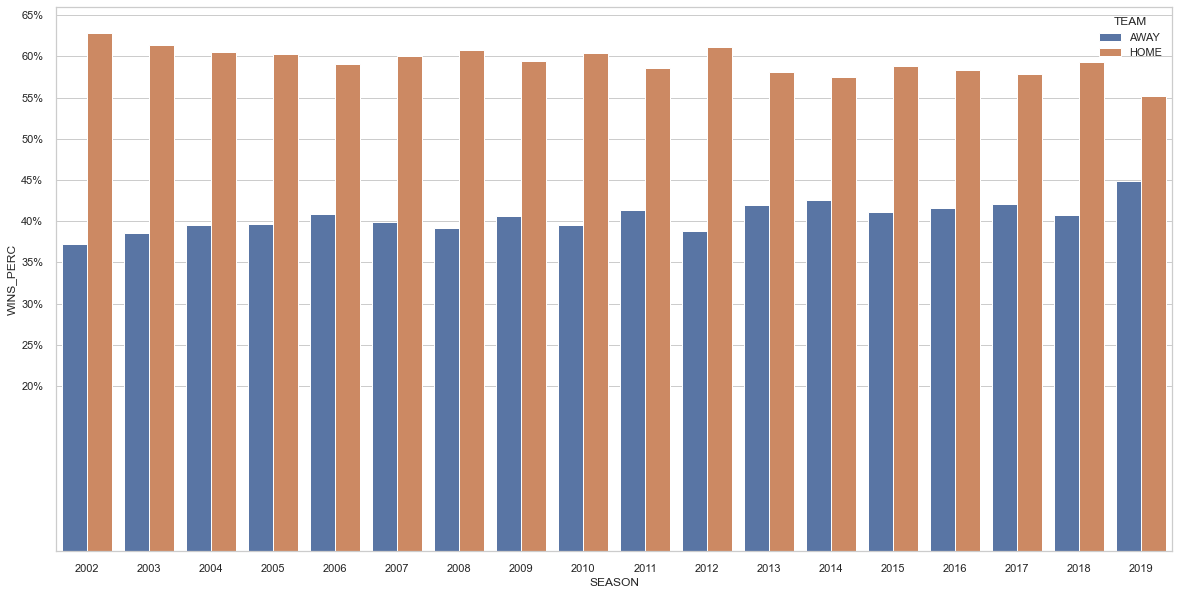

In [46]:
import matplotlib.ticker as mtick
import matplotlib.ticker as ticker
fig_dims = (20, 10)
fig, ax = plt.subplots(figsize=fig_dims, sharex=True, sharey=True)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.yaxis.set_major_locator(ticker.MultipleLocator(5))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(30))
ax.set_yticks(np.arange(20, 100,5))
sns.barplot(x="SEASON", y='WINS_PERC', hue="TEAM", data=plot_data, ax=ax)

In [48]:
wl_season_data = plot_data

### Three Points Field Goalds 

In [49]:
dfi = raw_ds
dfi

,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_DATE,MATCHUP,WL,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,...,W_L_CUM,W_L_L10_CUM,SEASON,LOCATION,UNIQUE_MATCHUP,FGM_ML5,FGA_ML5,FG_PCT_ML5,FG3M_ML5,FG3A_ML5,FG3_PCT_ML5,FTM_ML5,FTA_ML5,FT_PCT_ML5,OREB_ML5,DREB_ML5,REB_ML5,AST_ML5,STL_ML5,BLK_ML5,TOV_ML5,PF_ML5,PTS_ML5,PLUS_MINUS_ML5,W_L_ML5
GAME_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0020200001,22002,1610612753,ORL,Orlando Magic,2002-10-29,ORL vs. PHI,W,240,36,81,0.444,6,18,0.333,17,22,0.773,8,31,39,24,4,8,15,26,...,NaN,NaN,2002,HOME,1610612753-1610612755,43.2,89.2,0.4840,13.0,33.4,0.3882,11.6,14.2,0.8166,9.0,29.2,38.2,27.4,7.0,5.2,11.8,16.8,111.0,-2.6,-1.0
0020200001,22002,1610612755,PHI,Philadelphia 76ers,2002-10-29,PHI @ ORL,L,240,31,78,0.397,2,8,0.250,24,32,0.750,11,35,46,19,10,1,20,22,...,NaN,NaN,2002,AWAY,1610612753-1610612755,38.2,81.6,0.4676,10.6,28.8,0.3640,21.2,28.2,0.7368,8.0,36.4,44.4,28.6,6.2,7.0,12.2,19.4,108.2,7.6,5.0
0020200002,22002,1610612739,CLE,Cleveland Cavaliers,2002-10-29,CLE @ SAC,L,240,27,83,0.325,1,4,0.250,12,20,0.600,17,29,46,14,7,5,24,20,...,NaN,NaN,2002,AWAY,1610612739-1610612758,40.6,86.8,0.4692,10.6,29.8,0.3520,21.0,27.0,0.7736,8.8,32.6,41.4,20.6,5.8,3.8,9.0,18.0,112.8,-3.0,-1.0
0020200002,22002,1610612758,SAC,Sacramento Kings,2002-10-29,SAC vs. CLE,W,240,36,80,0.450,6,15,0.400,16,23,0.696,15,33,48,21,12,10,20,19,...,NaN,NaN,2002,HOME,1610612739-1610612758,40.2,85.0,0.4726,12.6,34.2,0.3648,11.8,16.4,0.7584,7.8,32.6,40.4,24.4,7.0,4.4,14.2,20.6,104.8,-3.8,-3.0
0020200003,22002,1610612747,LAL,Los Angeles Lakers,2002-10-29,LAL vs. SAS,L,240,27,85,0.318,4,13,0.308,24,30,0.800,17,31,48,16,10,5,18,34,...,NaN,NaN,2002,HOME,1610612747-1610612759,42.4,89.6,0.4722,14.6,39.8,0.3668,17.0,21.6,0.7780,11.4,36.6,48.0,28.6,7.6,5.0,16.2,19.4,116.4,3.2,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0021901316,22019,1610612754,IND,Indiana Pacers,2020-08-14,IND vs. MIA,W,240,43,89,0.483,15,38,0.395,8,11,0.727,12,39,51,32,11,3,20,27,...,16.0,4.0,2019,HOME,1610612748-1610612754,38.2,85.6,0.4458,10.8,28.8,0.3764,14.0,18.8,0.7612,6.4,34.8,41.2,24.0,8.6,4.2,13.2,17.4,101.2,-4.4,-1.0
0021901317,22019,1610612746,LAC,LA Clippers,2020-08-14,LAC vs. OKC,W,265,34,85,0.400,12,37,0.324,27,39,0.692,12,49,61,23,10,2,23,22,...,25.0,2.0,2019,HOME,1610612746-1610612760,38.0,83.6,0.4558,10.8,29.8,0.3742,19.8,26.4,0.7582,9.0,36.8,45.8,20.4,7.0,3.2,16.0,23.6,106.6,2.6,1.0
0021901317,22019,1610612760,OKC,Oklahoma City Thunder,2020-08-14,OKC @ LAC,L,265,38,106,0.358,14,44,0.318,13,22,0.591,11,37,48,18,5,6,16,29,...,17.0,4.0,2019,AWAY,1610612746-1610612760,38.2,89.0,0.4272,9.0,29.6,0.3144,18.6,24.8,0.7518,11.2,34.6,45.8,20.6,9.0,5.8,13.4,23.0,104.0,-2.6,-1.0


In [50]:
plot_data = dfi.groupby(by=["SEASON"]).mean()[["FGA", "FG3A"]].reset_index()
plot_data.SEASON.unique()

array([2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012,
       2013, 2014, 2015, 2016, 2017, 2018, 2019])

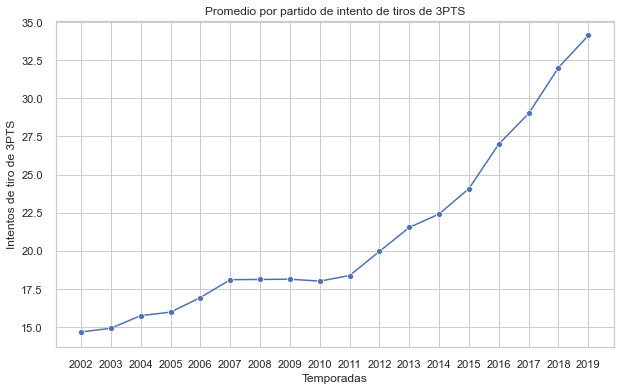

In [51]:
import matplotlib.ticker as ticker
fig_dims = (10, 6)
fig, ax = plt.subplots(figsize=fig_dims, sharex=True, sharey=True)
ax.set(xticks=plot_data.SEASON.unique())
ax = sns.lineplot(x=plot_data.SEASON.unique(), y=plot_data.FG3A.values, ax=ax, marker="o")
ax.set_title("Promedio por partido de intento de tiros de 3PTS")
ax.set(xlabel="Temporadas", ylabel = "Intentos de tiro de 3PTS")
plt.show()

In [52]:
winner_by_3pta = dataset.reset_index()
winner_by_3pta['WINNER_3PTA'] = 0
cond = ((winner_by_3pta.FG3A_HOME > winner_by_3pta.FG3A_AWAY) & (winner_by_3pta.HOME_WINS == 1))
winner_by_3pta.loc[cond, 'WINNER_3PTA'] = 1
cond = ((winner_by_3pta.FG3A_HOME < winner_by_3pta.FG3A_AWAY) & (winner_by_3pta.HOME_WINS == 0))
winner_by_3pta.loc[cond, 'WINNER_3PTA'] = 1

In [53]:
winner_by_3pta.groupby(by=["SEASON", 'WINNER_3PTA']).count()[['GAME_ID']]

GAME_ID
SEASON WINNER_3PTA         
2002   0                669
       1                520
2003   0                661
       1                528
2004   0                602
       1                628
2005   0                624
       1                606
2006   0                618
       1                612
2007   0                617
       1                613
2008   0                616
       1                614
2009   0                660
       1                570
2010   0                619
       1                611
2011   0                497
       1                493
2012   0                622
       1                607
2013   0                622
       1                608
2014   0                583
       1                647
2015   0                620
       1                610
2016   0                623
       1                607
2017   0                622
       1                608
2018   0                629
       1                601
2019   0                596
       1                463

In [ ]:
grouped = dfi[['SEASON', 'WL_HOME', 'GAME_ID']].groupby(by=['SEASON', 'WL_HOME']).count()
grouped = grouped.reset_index(level=0).reset_index(level=0)
grouped_total = grouped[['SEASON', 'GAME_ID']].groupby(by=['SEASON']).sum()
grouped_total = grouped_total.reset_index(level=0)
plot_data = pd.merge(grouped, grouped_total, suffixes=['', '_S'], on=['SEASON', 'SEASON'])
plot_data.rename(columns={"GAME_ID": "W_COUNT", "GAME_ID_S": "GAMES_COUNT"}, inplace=True)
plot_data["TEAM"] = np.where(plot_data['WL_HOME'] == 'W', 'HOME', 'AWAY')
plot_data["WINS_PERC"] = (plot_data["W_COUNT"] / plot_data["GAMES_COUNT"]) * 100
plot_data.head()

ValueError: Could not interpret input 'FG3A'

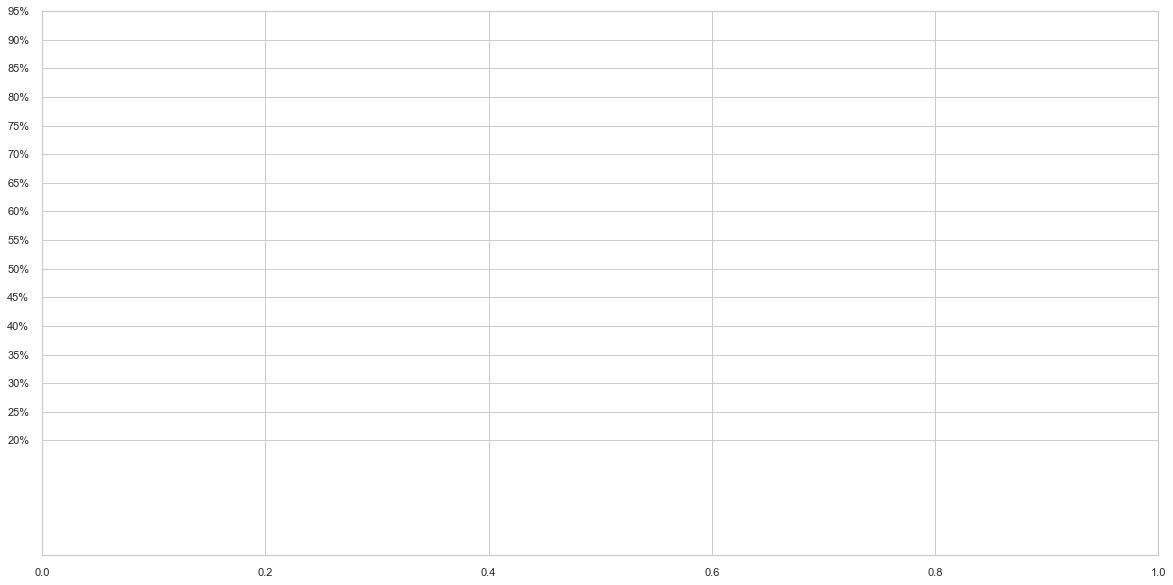

In [56]:
import matplotlib.ticker as mtick
import matplotlib.ticker as ticker
fig_dims = (20, 10)
fig, ax = plt.subplots(figsize=fig_dims, sharex=True, sharey=True)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.yaxis.set_major_locator(ticker.MultipleLocator(5))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(30))
ax.set_yticks(np.arange(20, 100,5))
sns.barplot(x="SEASON", y='FG3A', hue="LOCATION", data=plot_data, ax=ax)

### How much have offensive NBA stats changed over time?

In [55]:
plot_data = dfi.groupby(by=["SEASON"]).mean()[['FGA', 'REB', "AST", 'STL', 'PTS']].reset_index()

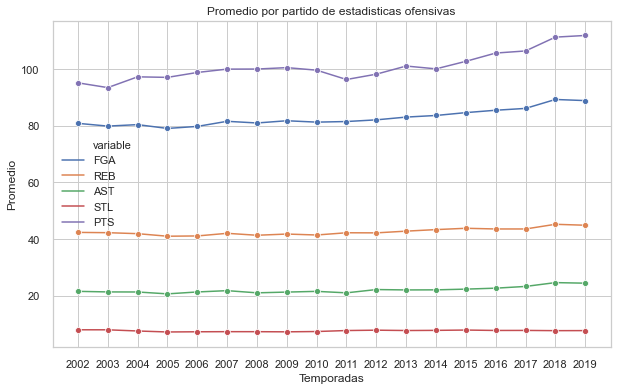

In [66]:
import matplotlib.ticker as ticker
fig_dims = (10, 6)
fig, ax = plt.subplots(figsize=fig_dims, sharex=True, sharey=True)
ax.set(xticks=plot_data.SEASON.unique())
ax = sns.lineplot(data=pd.melt(plot_data, ['SEASON']), x='SEASON', y='value', hue='variable', ax=ax, marker="o")
ax.set_title("Promedio por partido de estadisticas ofensivas")
ax.set(xlabel="Temporadas", ylabel = "Promedio")
plt.show()

## Features  correlations

### Utils functions

In [18]:
def plot_heatmap(data, title):
    mask = np.zeros_like(pearson_corr)
    mask[np.triu_indices_from(mask)] = True
    with sns.axes_style("white"):
        f, ax = plt.subplots(figsize = (30, 24))
        heatmap = sns.heatmap(data, mask=mask, square=True,
                        linewidth=1,
                        annot=True,
                        annot_kws={'size' : 10} 
                        )
#     plt.figure(figsize = (30, 24))
#     heatmap = sns.heatmap(data,
#             linewidth=1,
#             annot=True,
#             annot_kws={'size' : 10} )
    plt.title(title, fontsize=25)
    plt.show()
    return heatmap

def save_heatmap(heatmap, name):
    figure = heatmap.get_figure()    
    figure.savefig(f'plots/{name}.png')
    
def top_corr_features(corr):
    c = corr.abs()
    sol = (c.where(np.triu(np.ones(c.shape), k=1).astype(np.bool))
                 .stack()
                 .sort_values(ascending=False))
    return pd.DataFrame(sol)

### Generate correlation matrix

In [13]:
pearson_corr = df.corr(method='pearson')
spearman_corr = df.corr(method='spearman')
kendall_corr = df.corr(method='kendall')

### Pearson Correlations

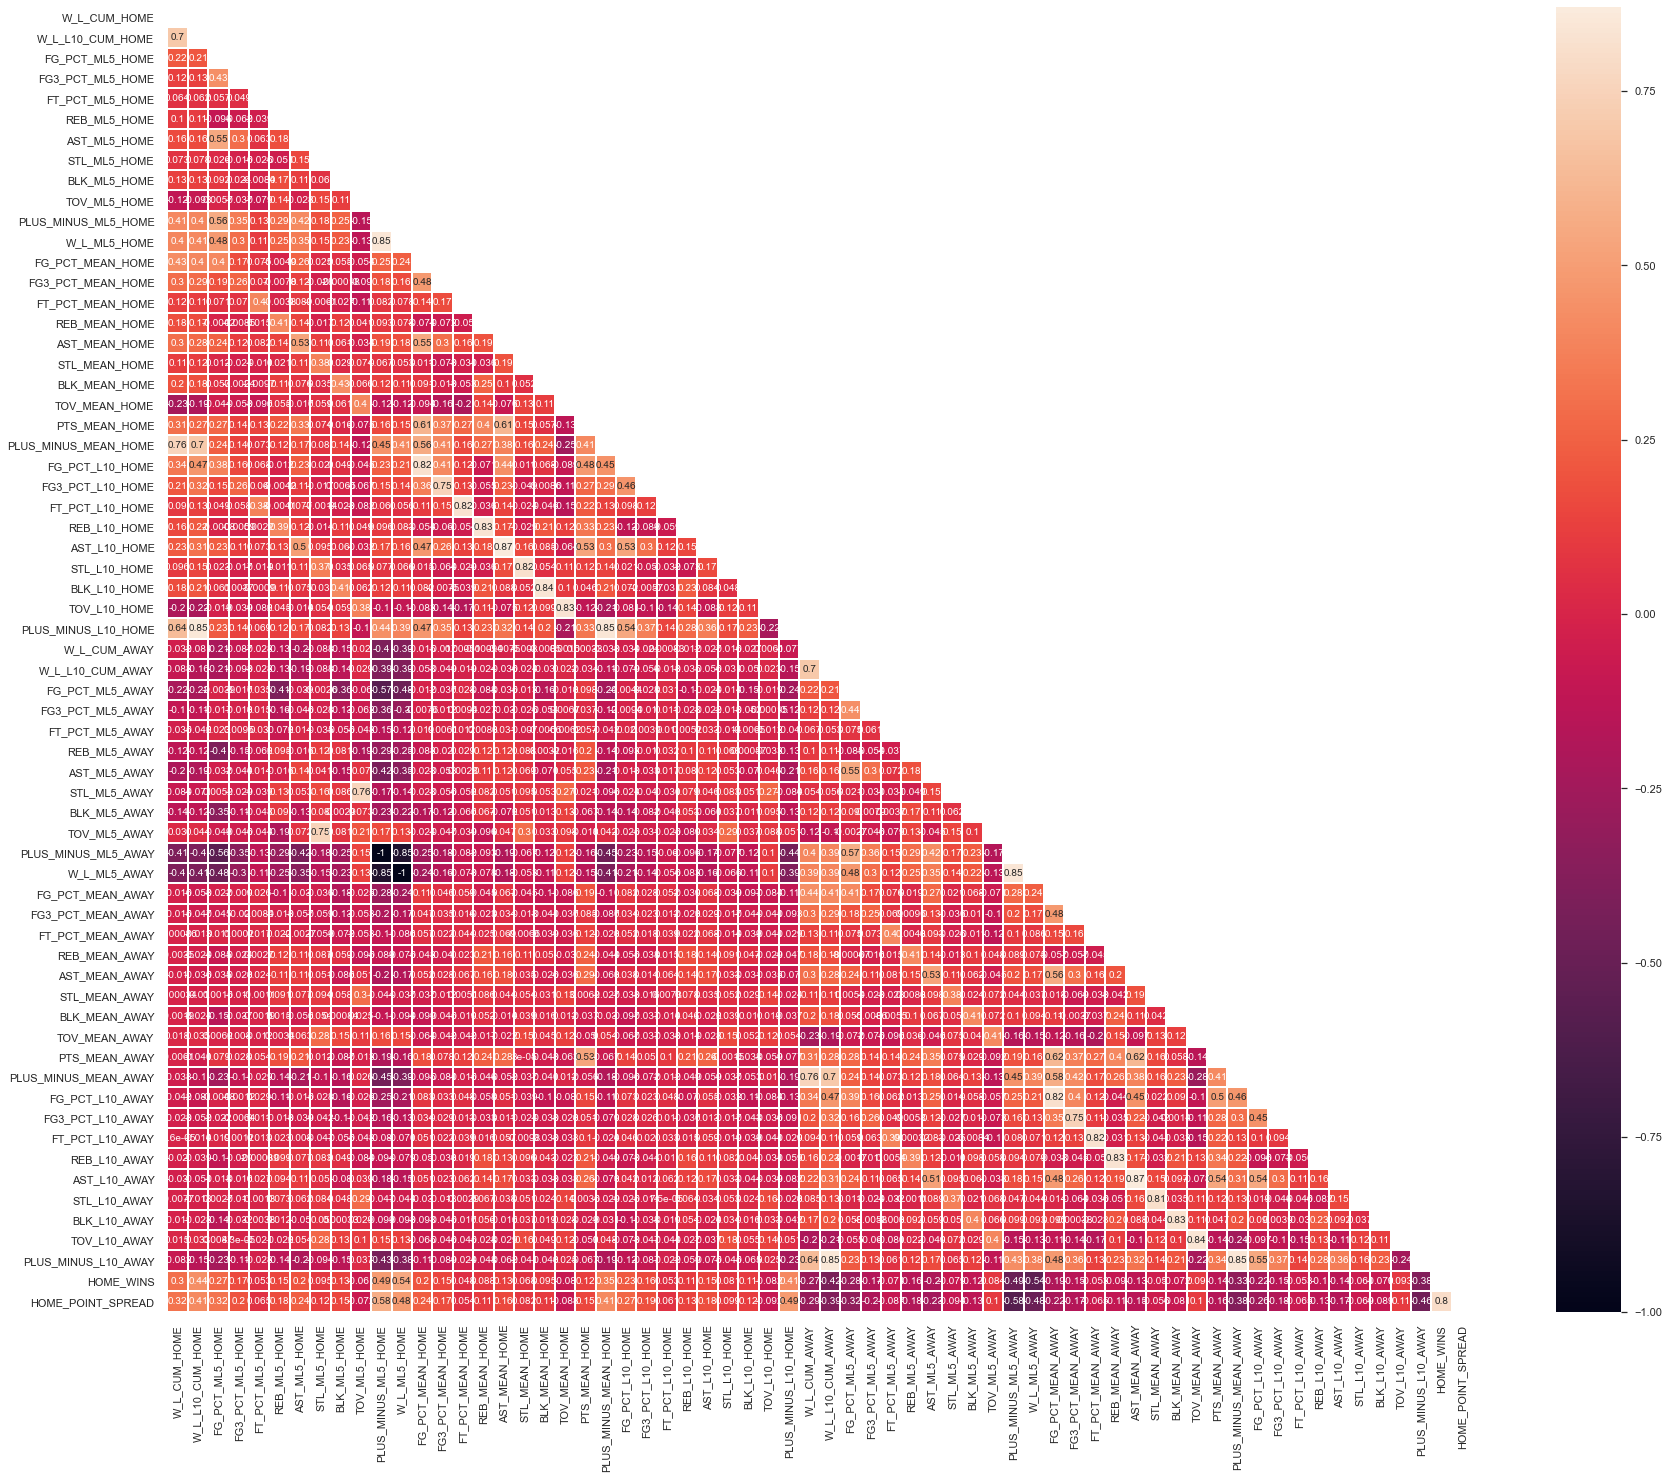

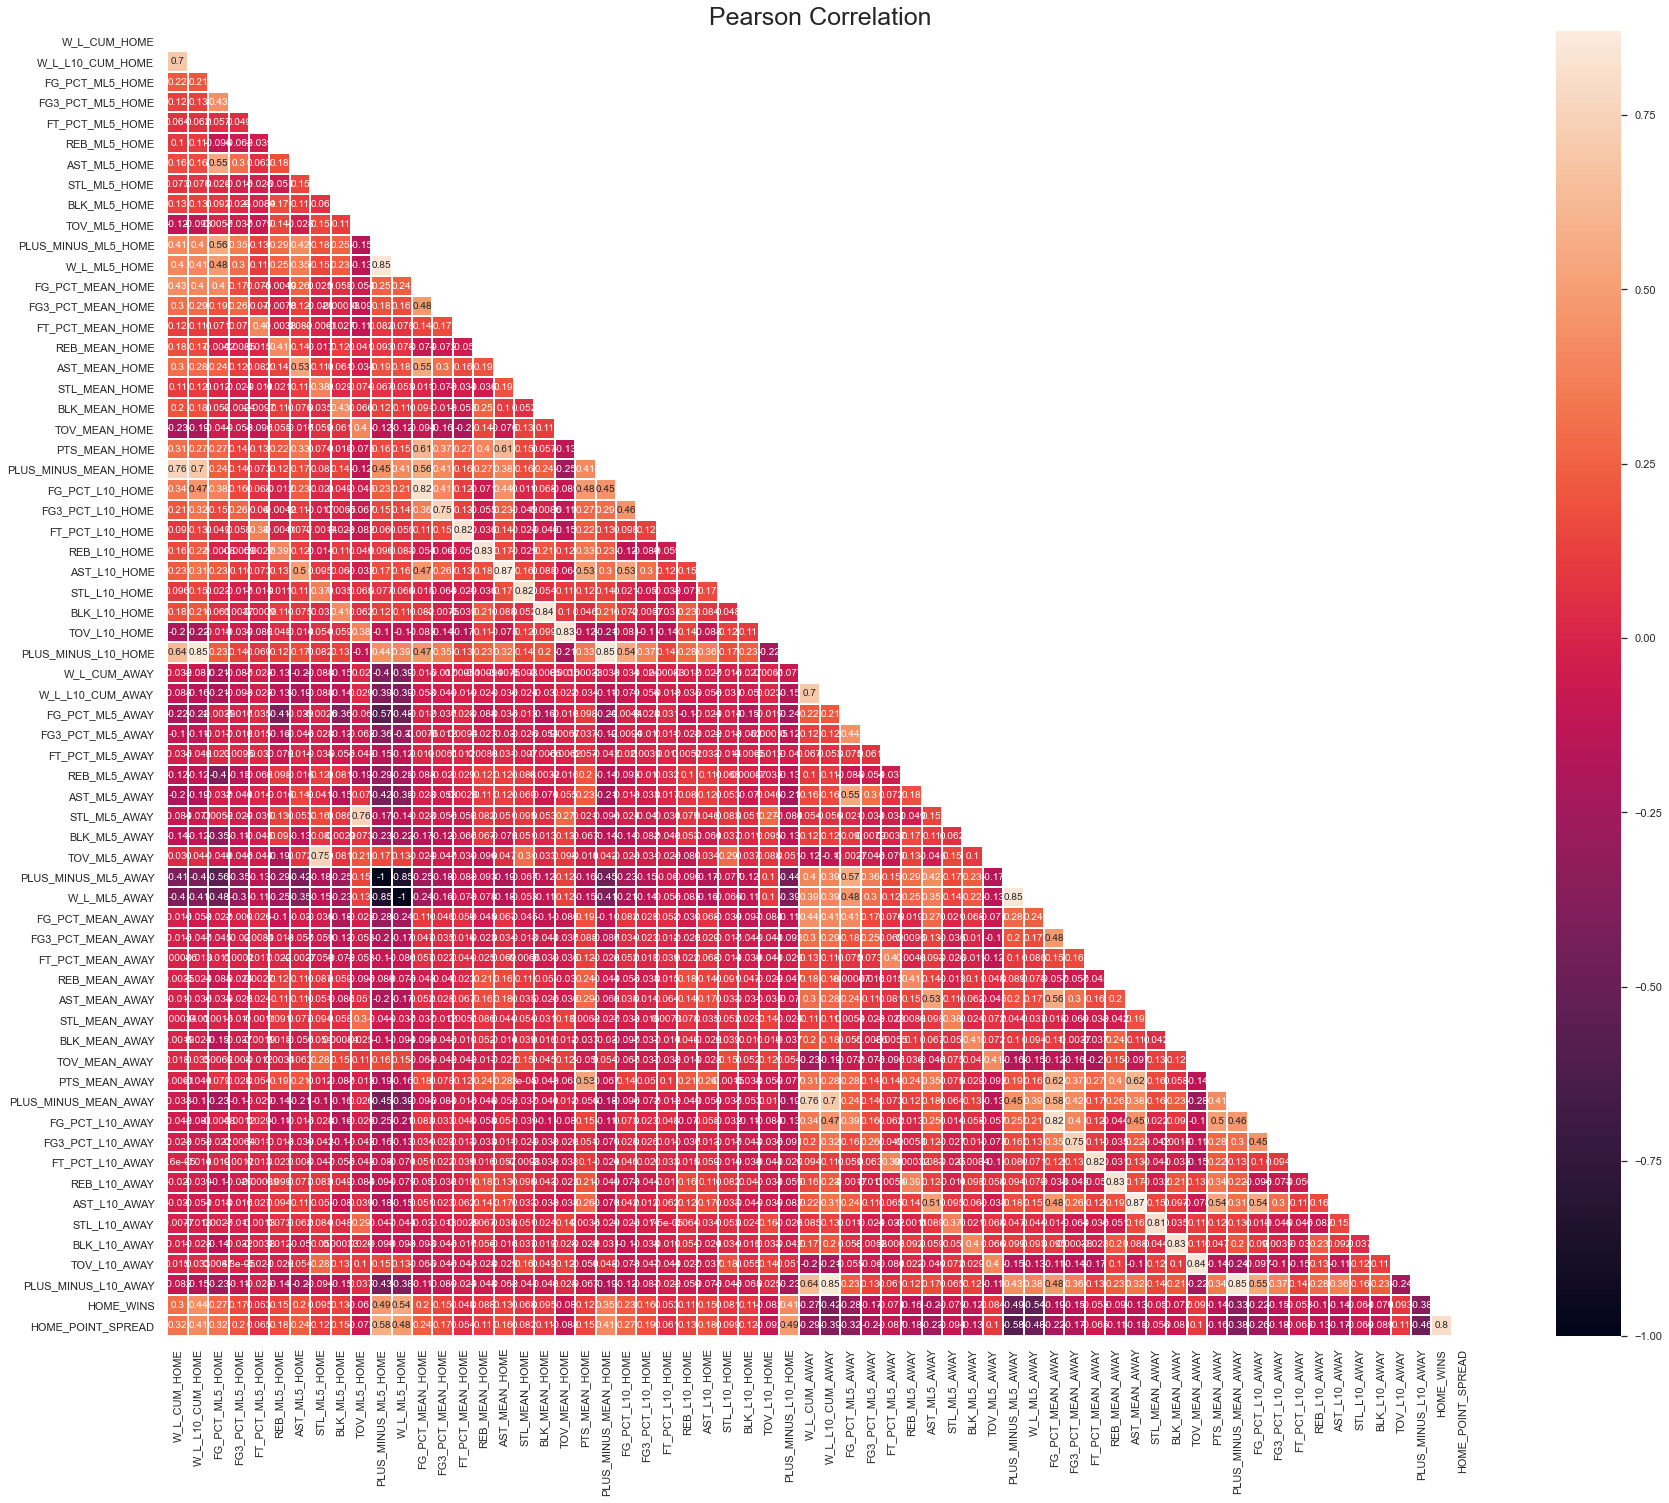

In [14]:
mask = np.zeros_like(pearson_corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize = (30, 24))
    ax = sns.heatmap(pearson_corr, mask=mask, square=True,
                    linewidth=1,
                    annot=True,
                    annot_kws={'size' : 10} 
                    )
save_heatmap(plot_heatmap(pearson_corr, "Pearson Correlation"), "pearson_corr")

In [15]:
top_corr_features_df = top_corr_features(pearson_corr)
qgrid_widget = qgrid.show_grid(top_corr_features_df, show_toolbar=True , grid_options={'forceFitColumns': False, 'defaultColumnWidth': 200})
qgrid_widget

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': False, 'defa…

Se observa que existe muchos features altamente correlacionados, por lo que se evaluara que tan insprecindible son y como es el comportamiento de los experimentos al eliminar estos.

### Spearman Correlation

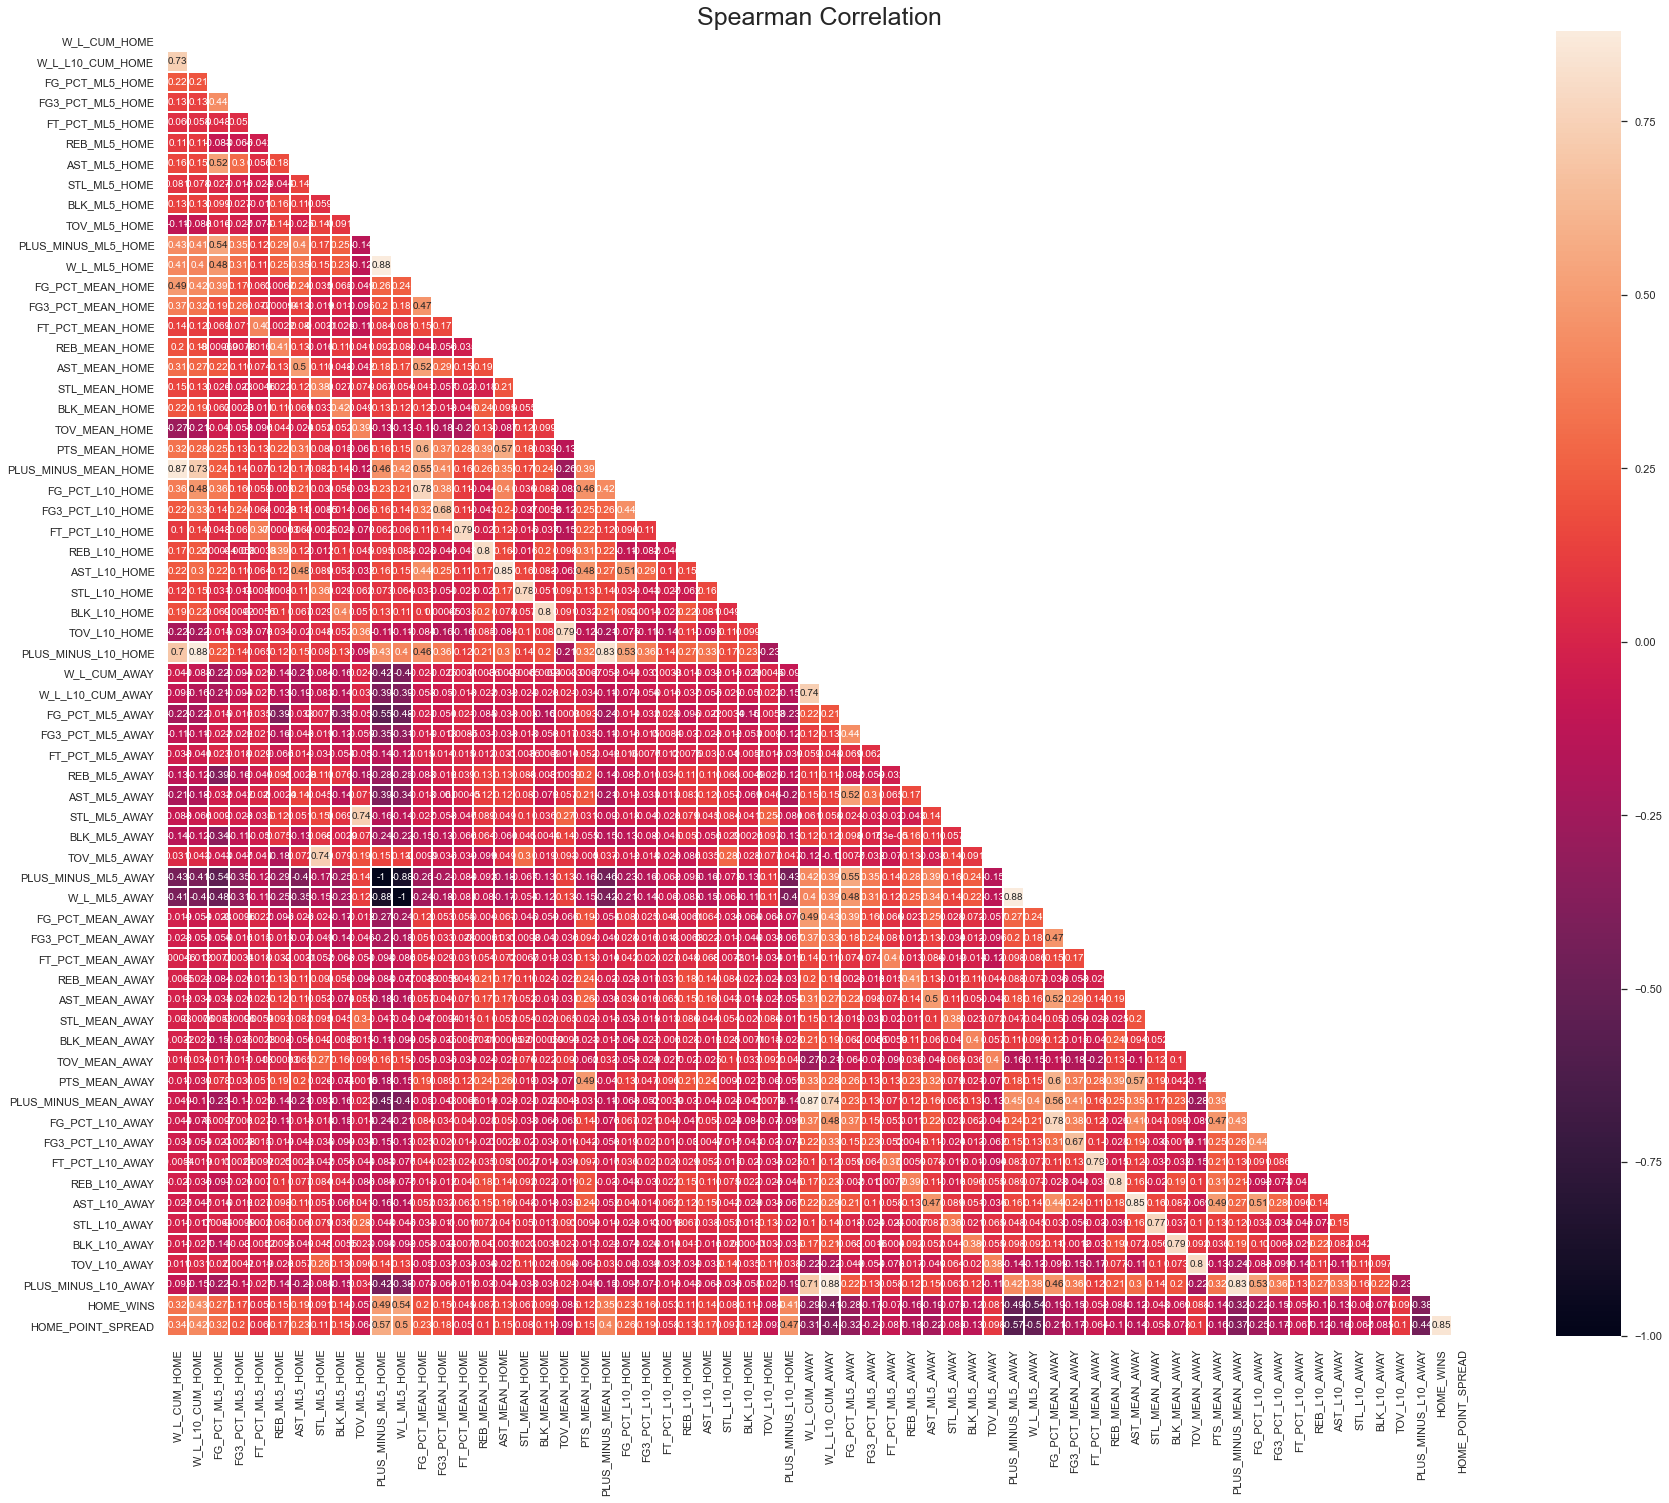

In [16]:
save_heatmap(plot_heatmap(spearman_corr, "Spearman Correlation"), "spearman_corr")

In [17]:
top_corr_features_df = top_corr_features(spearman_corr)
qgrid_widget = qgrid.show_grid(top_corr_features_df, show_toolbar=True , grid_options={'forceFitColumns': False, 'defaultColumnWidth': 200})
qgrid_widget

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': False, 'defa…

### __Kendall correlation__

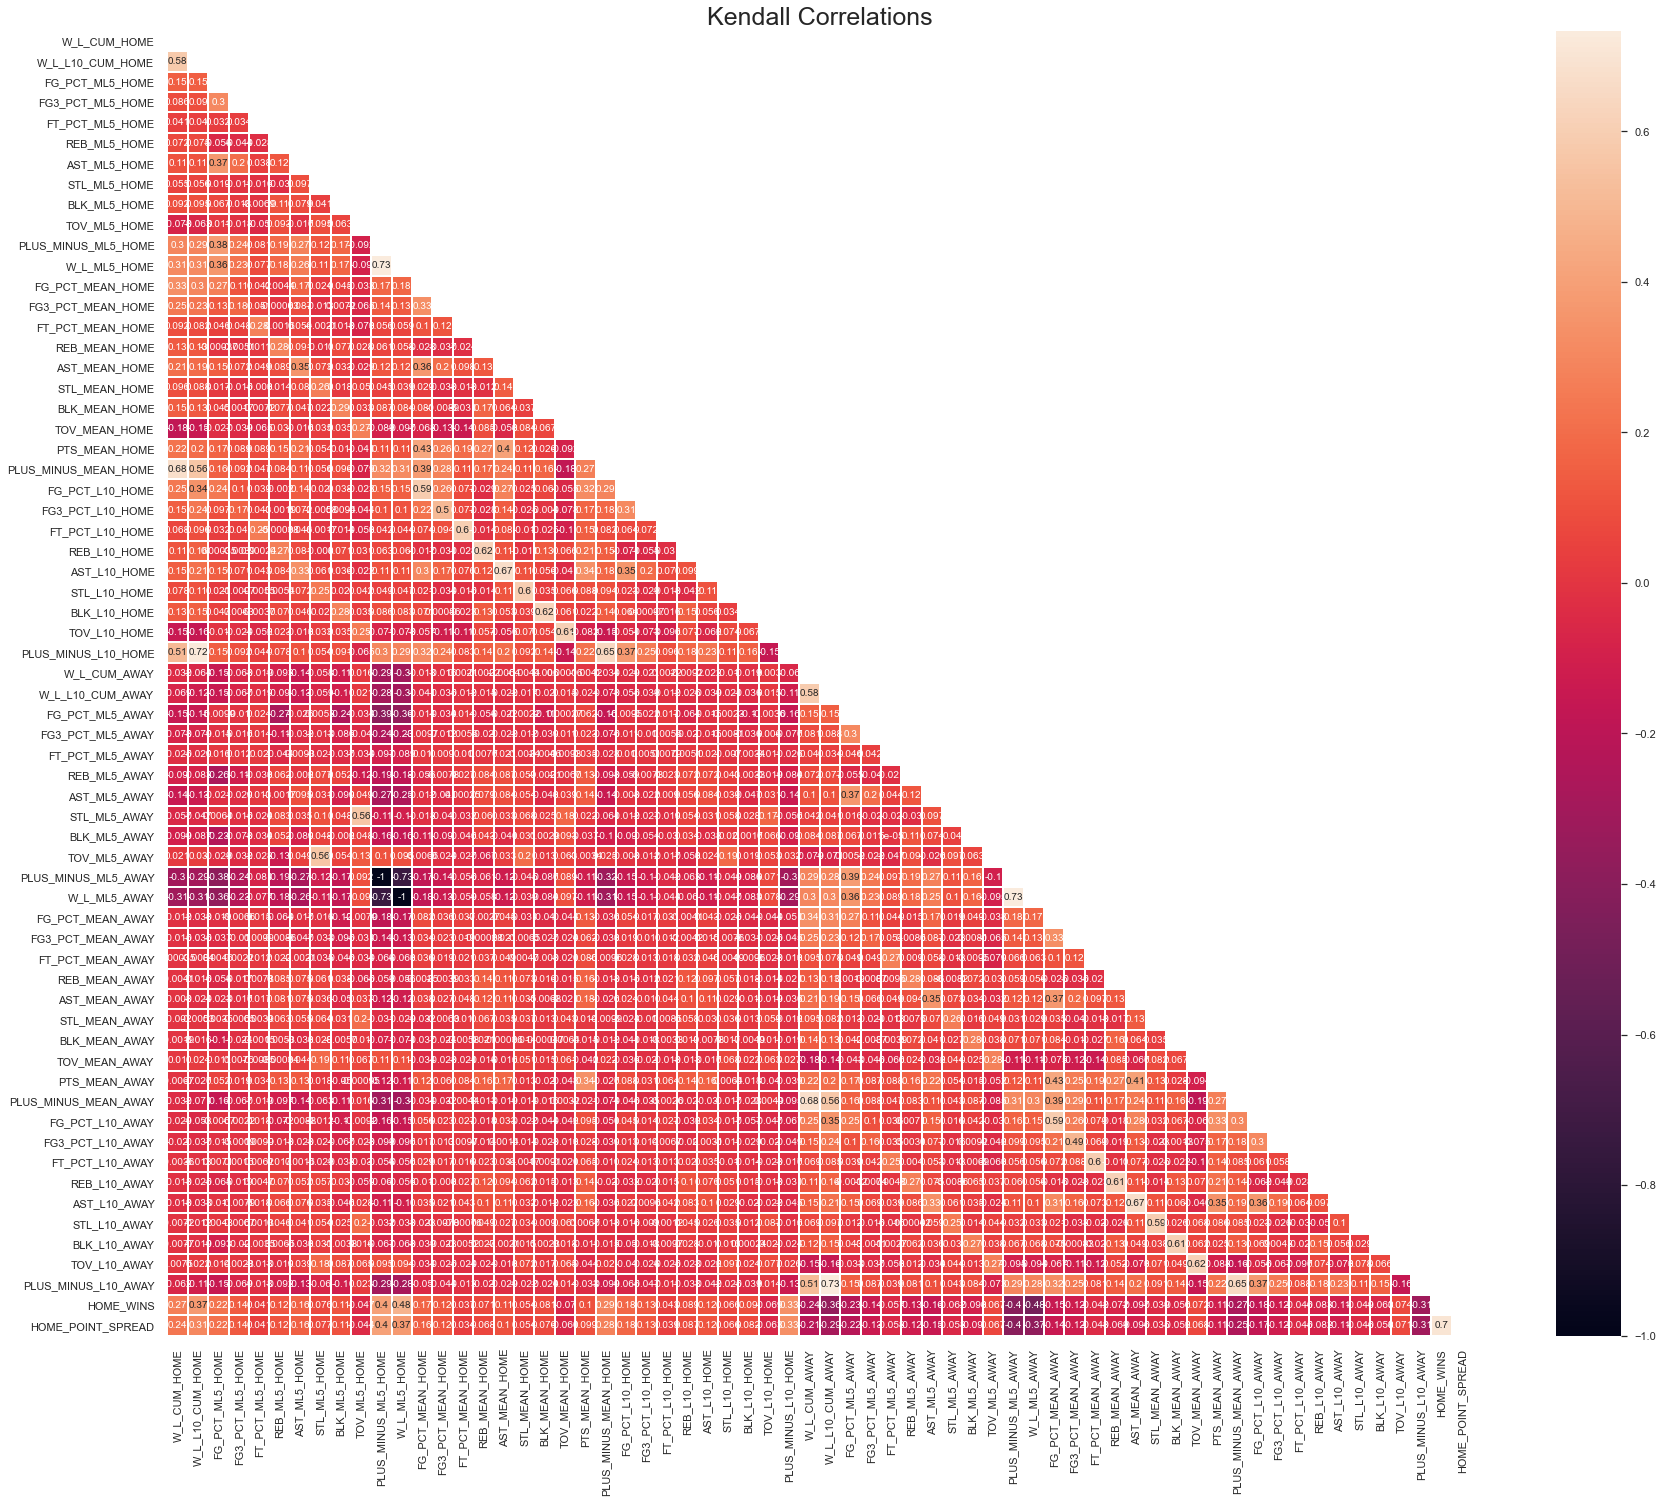

In [18]:
save_heatmap(plot_heatmap(kendall_corr, "Kendall Correlations"), "kendall_corr")

In [19]:
top_corr_features_df = top_corr_features(kendall_corr)
qgrid_widget = qgrid.show_grid(top_corr_features_df, show_toolbar=True , grid_options={'forceFitColumns': False, 'defaultColumnWidth': 200})
qgrid_widget

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': False, 'defa…

## Generate Panda Profiling Report

In [20]:
profile = ProfileReport(df, title='Pandas Profiling Report', pool_size=4,
                        minimal=True,
                        explorative=True,
                           correlations={
             "pearson": {"calculate": True},
             "spearman": {"calculate": True},
             "kendall": {"calculate": True},
             "phi_k": {"calculate": False},
             "cramers": {"calculate": False},
         })

In [21]:
profile.to_file("plots/season_games_profile_report.html")

Para visualizar el reporte generado puede acceder a este link:

[Panda Profiling Report](plots/season_games_profile_report.html)

## Generate sweetviz report

In [ ]:
#analyzing the dataset
report = sv.analyze(df)
#display the report
report.show_html('plots/sweetviz_report.html')

Para visualizar el reporte generado puede acceder a este link:

[Sweetviz](plots/sweetviz_report.html)

## Visualization of correlation between dependent variable and features

In [ ]:
#target = df[config.y_columns]
target = df["HOME_TEAM_WINS"]
features = df.drop(config.y_columns, axis=1)

### Drop categorical values

In [ ]:
#features.drop(["HT_RANK", "HT_CLASS", "VT_RANK", "VT_CLASS"], axis=1, inplace=True)

In [ ]:
features_names = list(features.columns)

## Yellowbrick Visualizer

In [ ]:
plt.figure(figsize = (15, 15))
visualizer = FeatureCorrelation(labels=features_names)
visualizer.fit(features, target)
visualizer.poof()